In [1]:
# library imports
import numpy as np 
import pandas as pd
import random as rn
import cv2 as cv 
import os
import sys
from pathlib import Path

# neural network wizardry
import tensorflow as tf

# visuals
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# paths
img_train_folder = Path('/kaggle/input/train_images/')
img_test_folder = Path('/kaggle/input/test_images/')

<a id="1"></a> <br>
# Competition Information

## Prediction Output Format
From the competition's [data](https://www.kaggle.com/c/severstal-steel-defect-detection/data) page:
> Each image may have no defects, a defect of a single class, or defects of multiple classes. For each image you must segment defects of each class ```(ClassId = [1, 2, 3, 4])```.

## Explortory Data Analysis

In [2]:
# reading in the training set
data = pd.read_csv('/kaggle/input/train.csv')

# storing a list of images without defects for later use and testing
no_defects = data[data['EncodedPixels'].isna()] \
                [['ImageId']] \
                .drop_duplicates()

# adding the columns so we can append (a sample of) the dataset if need be, later
no_defects['EncodedPixels'] = ''
no_defects['ClassId'] = np.empty((len(no_defects), 0)).tolist()
no_defects['Distinct Defect Types'] = 0
no_defects.reset_index(inplace=True)

In [3]:
# keep only the images with labels
squashed = data.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

# squash multiple rows per image into a list
squashed = data[['ImageId', 'EncodedPixels', 'ClassId']] \
            .groupby('ImageId', as_index=False) \
            .agg(list) \

# count the amount of class labels per image
squashed['Distinct Defect Types'] = squashed.ClassId.apply(lambda x: len(x))

# display first ten to show new structure
squashed.head(10)

ImageId                                      EncodedPixels ClassId  \
0  0002cc93b.jpg  [29102 12 29346 24 29602 24 29858 24 30114 24 ...     [1]   
1  0007a71bf.jpg  [18661 28 18863 82 19091 110 19347 110 19603 1...     [3]   
2  000a4bcdd.jpg  [37607 3 37858 8 38108 14 38359 20 38610 25 38...     [1]   
3  000f6bf48.jpg  [131973 1 132228 4 132483 6 132738 8 132993 11...     [4]   
4  0014fce06.jpg  [229501 11 229741 33 229981 55 230221 77 23046...     [3]   
5  0025bde0c.jpg  [8458 14 8707 35 8963 48 9219 71 9475 88 9731 ...  [3, 4]   
6  002af848d.jpg  [290800 6 291055 13 291311 15 291566 18 291822...     [4]   
7  002fc4e19.jpg  [146021 3 146275 10 146529 40 146783 46 147038...  [1, 2]   
8  0030401a5.jpg  [186833 1 187089 3 187344 6 187600 7 187855 10...     [4]   
9  0046839bd.jpg  [152926 1 153180 4 153434 6 153689 8 153943 11...     [3]   

   Distinct Defect Types  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
5                      2  
6                      1  
7                      2  
8                      1  
9                      1

In [4]:
print(f"""The training set now consists of {len(squashed):,} distinct images,
for a total of {squashed["Distinct Defect Types"].sum():,} labeled mask instances.

Furthermore, we have kept a backup of {len(no_defects):,} images witout defects,
in case our model starts producing a lot of false positives and needs more training
on a background class.""")

The training set now consists of 6,666 distinct images,
for a total of 7,095 labeled mask instances.

Furthermore, we have kept a backup of 0 images witout defects,
in case our model starts producing a lot of false positives and needs more training
on a background class.


In [5]:
""" use a consistent color palette per label throughout the notebook """
import colorlover as cl

# see: https://plot.ly/ipython-notebooks/color-scales/
colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1,5))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

In [6]:
# we want counts & frequency of the labels
classes = data.groupby(by='ClassId', as_index=False) \
               .agg({'ImageId':'count'}) \
               .rename(columns={'ImageId':'Count'})

classes['Frequency'] = round(classes.Count / classes.Count.sum() * 100, 2) 
classes['Frequency'] = classes['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=classes.Count,
        y=classes.ClassId,
        hovertext=classes.Frequency,
        text=classes.Count,
        textposition='auto',
        marker_color=colors),
    
    layout=go.Layout(
        title='Defect Type: Count & Frequency',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=400
    )
)

# display
fig.show()

An overwhelming amount of the observations is for class 3. Hopefully we can balance this out at least a little with some data augmentation later.

Let's see what the distributions are if we consider all possible combinations, inccluding multi-class instances.

In [7]:
# we want counts of the possible combinations of labels
permutations = pd.DataFrame(data=squashed.ClassId.astype(str).value_counts())

# and their frequency
permutations['Frequency'] = round(permutations.ClassId / permutations.ClassId.sum() * 100, 2)
permutations['Frequency'] = permutations['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=permutations.ClassId,
        y=permutations.index,
        hovertext=permutations.Frequency,
        text=permutations.ClassId,
        textposition='auto'),
    
    layout=go.Layout(
        title='Count of Distinct Defect Combinations in Images',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=500
    )
)

# display
fig.show()

It looks like combinations of two labels in a single image are reasonably frequent, too. In fact, 3 & 4 appear together more often than 2 does on its own!

<a id="3"></a> <br>
# Data Shapes

## Images
The input shape will be an image we convert to a three-dimensional array with shape ```(256, 1600, 3)```, for height, width, and the three colour channels (RGB), respectively.

## Labels
Naturally, the masks will share the same width and height, but the third dimension will be as large as there are labels ```(256, 1600, 4)```, with each class occupying a different layer. Somewhat like this:
![label shape](https://i.imgur.com/PePSemo.png)

## Batch Size
To leverage the parellel computation a GPU offers, we will feed the images and their labels to the algorithm in batches. Consequently, our array dimensions will be expanded to ```(batch size, 256, 1600, 3)``` and ```(batch size, 256, 1600, 4)```, respectively.

If you remember our dice coefficient, we will have to calculate it for evey layer in every mask, and take the average over the entire batch.

<a id="4"></a> <br>
# Visualising the Masks
Let's take a look at some examples of each class, and of some of the images containing multiple classes.

In [8]:
def build_mask(encodings, labels):
    """ takes a pair of lists of encodings and labels, 
        and turns them into a 3d numpy array of shape (256, 1600, 4) 
    """
    
    # initialise an empty numpy array 
    mask = np.zeros((256,1600,4), dtype=np.uint8)
   
    # building the masks
    for rle, label in zip(encodings, labels):
        
        # classes are [1, 2, 3, 4], corresponding indeces are [0, 1, 2, 3]
        index = label - 1
        
        # fit the mask into the correct layer
        # note we need to transpose the matrix to account for 
        # numpy and openCV handling width and height in reverse order 
        mask[:,:,index] = rle_to_mask(rle).T
    
    return mask

In [9]:
def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """

    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image = cv.drawContours(image, contours, -1, color, 2)
        
    return image

In [10]:
def visualise_mask(file_name, mask):
    """ open an image and draws clear masks, so we don't lose sight of the 
        interesting features hiding underneath 
    """
    
    # reading in the image
    image = cv.imread(f'{img_train_folder}/{file_name}')

    # going through the 4 layers in the last dimension 
    # of our mask with shape (256, 1600, 4)
    for index in range(mask.shape[-1]):
        
        # indeces are [0, 1, 2, 3], corresponding classes are [1, 2, 3, 4]
        label = index + 1
        
        # add the contours, layer per layer 
        image = mask_to_contours(image, mask[:,:,index], color=palette[label])   
        
    return image

In [11]:
def rle_to_mask(lre, shape=(1600,256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape)

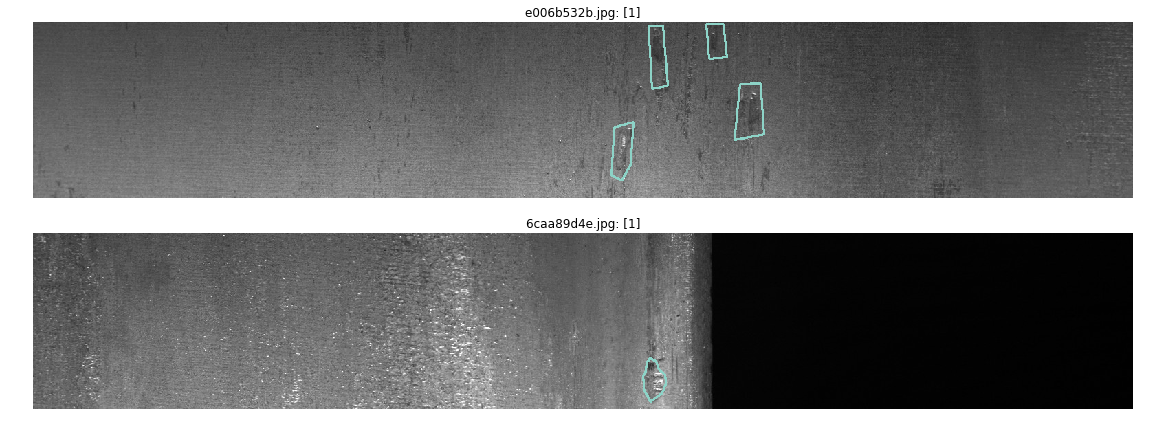

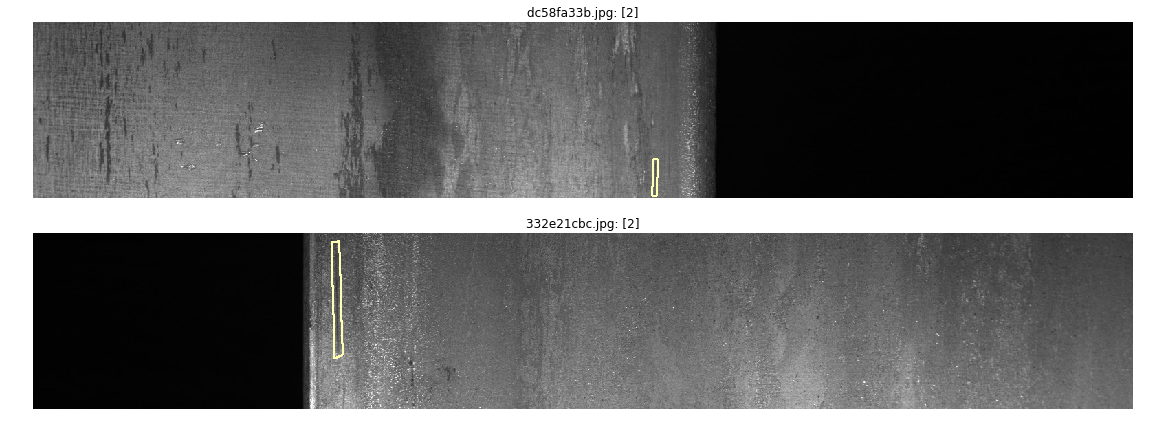

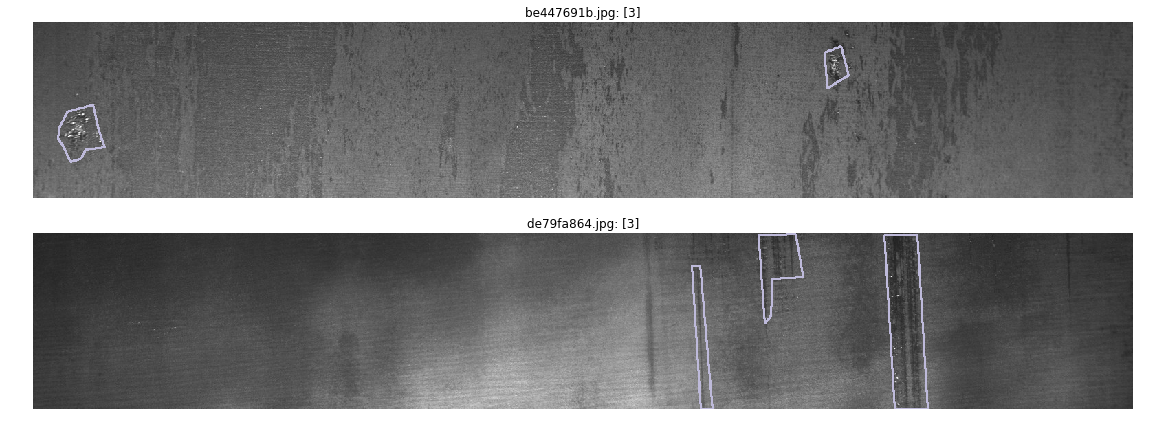

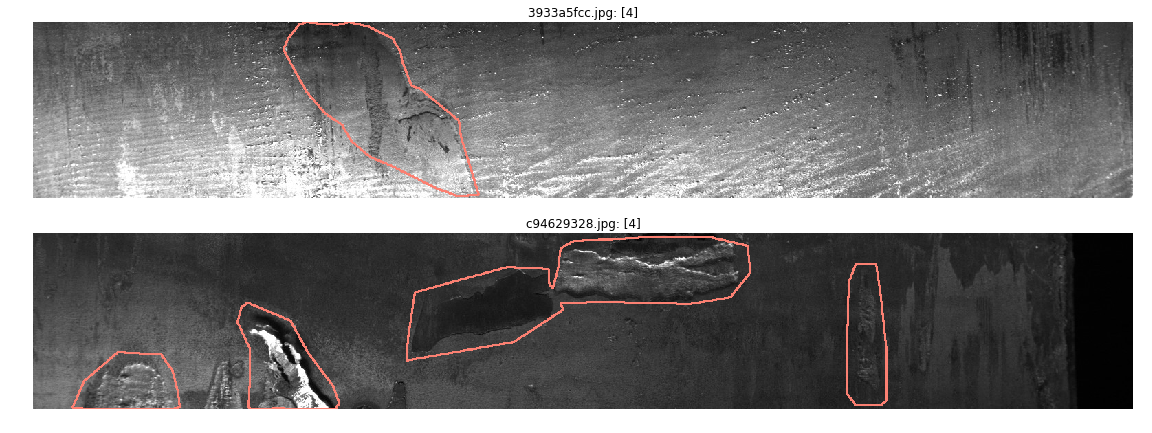

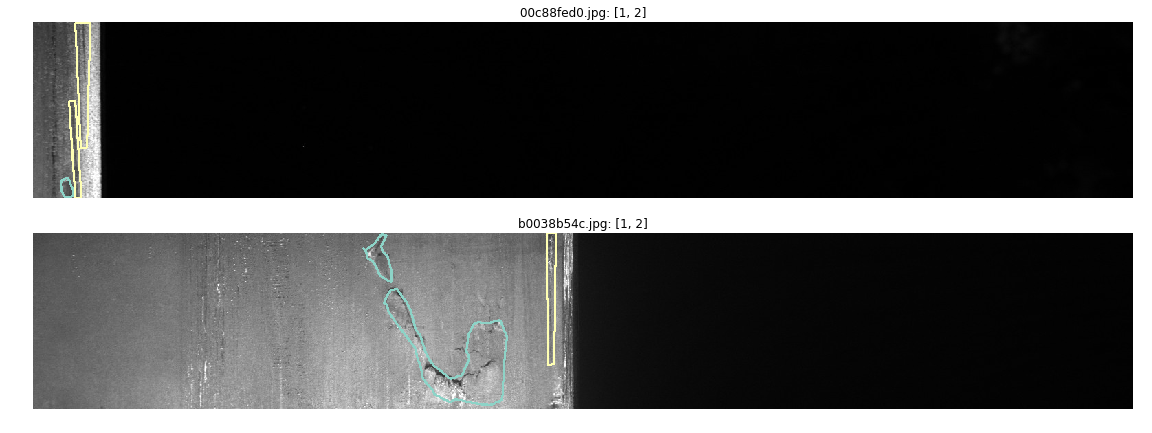

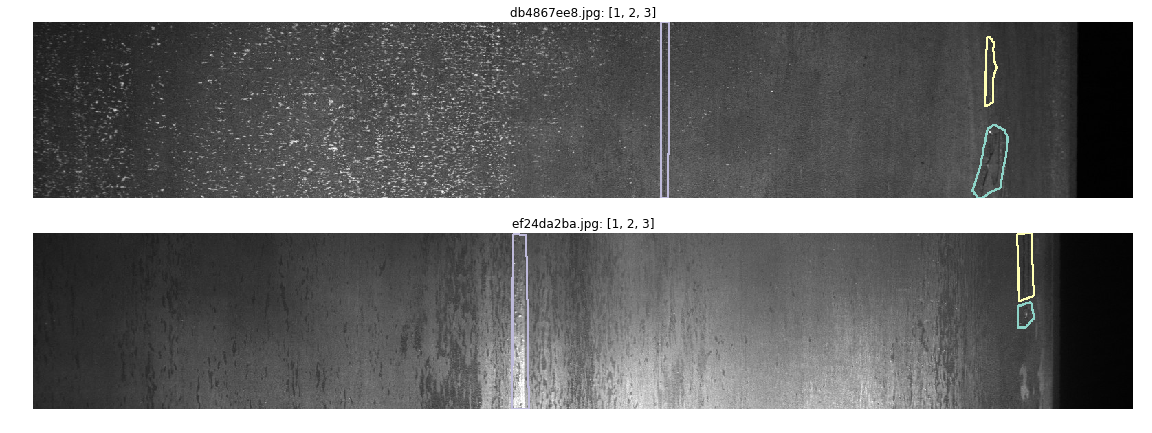

In [12]:
# the images we want to see
conditions = [
    squashed['ClassId'].astype(str)=='[1]',
    squashed['ClassId'].astype(str)=='[2]',
    squashed['ClassId'].astype(str)=='[3]',
    squashed['ClassId'].astype(str)=='[4]',
    squashed['Distinct Defect Types']==2,
    squashed['Distinct Defect Types']==3
]

# max 2 due to limited population of [squashed['Distinct Defect Types']==3]
# remove that condition if you wish to increase the sample size, 
# or add replace=True to the .sample() method
sample_size = 2

# looping over the different combinations of labels 
for condition in conditions:
    
    # isolate from dataset and draw a sample
    sample = squashed[condition].sample(sample_size) 
    
    # make a subplot+
    fig, axes = plt.subplots(sample_size, 1, figsize=(16, sample_size*3))
    fig.tight_layout()
    
    # looping over sample
    for i, (index, row) in enumerate(sample.iterrows()):
        
        # current ax
        ax = axes[i,]
        
        # build the mask
        mask = build_mask(encodings=row.EncodedPixels, labels=row.ClassId)

        # fetch the image and draw the contours
        image = visualise_mask(file_name=row.ImageId, mask=mask)
        
        # display
        ax.set_title(f'{row.ImageId}: {row.ClassId}')
        ax.axis('off')
        ax.imshow(image);

In [13]:
# load full data and label no mask as -1
train_df = pd.read_csv('../input/train.csv').fillna(-1)

In [14]:
print('Total number of images: %s' % len(train_df['ImageId'].unique()))
print('Images with at least one label: %s' % len(train_df[train_df['EncodedPixels'] != -1]['ImageId'].unique()))
print('Total instance or examples of defects: %s' % len(train_df[train_df['EncodedPixels'] != -1]))

Total number of images: 6666
Images with at least one label: 6666
Total instance or examples of defects: 7095


### Missing Labels & Defect Per Image

In [15]:
# calculate sum of the pixels for the mask per class id
train_df['mask_pixel_sum'] = train_df.apply(lambda x: rle_to_mask(x['EncodedPixels']).sum(), axis=1)

In [16]:
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_df['ClassId_EncodedPixels'] = train_df.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)
grouped_EncodedPixels = train_df.groupby('ImageId')['ClassId_EncodedPixels'].apply(list)

In [17]:
# calculate the number of pictures without any label what so ever
annotation_count = grouped_EncodedPixels.apply(lambda x: 1 if len([1 for y in x if y[1] != -1]) > 0 else 0).value_counts()
annotation_count_labels = ['No Label' if x == 0 else 'Label' for x in annotation_count.index]
# calculate number of defects per image 
defects_count_df = grouped_EncodedPixels.apply(lambda x: len([1 for y in x if y[1] != -1]))
defect_count_per_image = defects_count_df.value_counts()
defect_count_labels = defect_count_per_image.index

In [18]:
# visualization
import matplotlib.pyplot as plt
# plotly offline imports
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import subplots
import plotly.express as px
import plotly.figure_factory as ff
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis
init_notebook_mode()
# frequent pattern mining
from mlxtend.frequent_patterns import fpgrowth

In [19]:
# load full data and label no mask as -1
df = pd.read_csv('../input/train.csv').fillna(-1)

In [20]:
print('Total number of images: %s' % len(df['ImageId'].unique()))
print('Images with at least one label: %s' % len(df[train_df['EncodedPixels'] != -1]['ImageId'].unique()))
print('Total instance or examples of defects: %s' % len(df[train_df['EncodedPixels'] != -1]))

Total number of images: 6666
Images with at least one label: 6666
Total instance or examples of defects: 7095


In [21]:
trace1 = Bar(x=defect_count_labels, y=defect_count_per_image, name = 'Defects Per Image')
fig = subplots.make_subplots(rows=1, cols=2)
fig.append_trace(trace1, 1, 1)
fig['layout'].update(height=400, width=900, title='Defect Labels and Defect Frequency Per Image')
iplot(fig)

In [22]:
class_ids = ['1','2','3','4']
mask_count_per_class = [train_df[(train_df['ClassId']==class_id)&(train_df['mask_pixel_sum']!=0)]['mask_pixel_sum'].count() for class_id in class_ids]
pixel_sum_per_class = [train_df[(train_df['ClassId']==class_id)&(train_df['mask_pixel_sum']!=0)]['mask_pixel_sum'].sum() for class_id in class_ids]

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [23]:
'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [24]:
'''A Function To Plot Pie Plot using Plotly'''

def pie_plot(cnt_srs, colors, title):
    labels=cnt_srs.index
    values=cnt_srs.values
    trace = go.Pie(labels=labels, 
                   values=values, 
                   title=title, 
                   hoverinfo='percent+value', 
                   textinfo='percent',
                   textposition='inside',
                   hole=0.7,
                   showlegend=True,
                   marker=dict(colors=colors,
                               line=dict(color='#000000',
                                         width=2),
                              )
                  )
    return trace

#bold("**NETFLIX HAVE MORE MOVIES THAN TV SHOWS**")
#py.iplot([pie_plot(df['type'].value_counts(), ['cyan', 'gold'], 'Content Type')])

In [25]:
train_df.head()

ImageId  ClassId                                      EncodedPixels  \
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...   
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...   
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...   
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...   

   mask_pixel_sum                              ClassId_EncodedPixels  
0            4396  (1, 29102 12 29346 24 29602 24 29858 24 30114 ...  
1            6897  (3, 18661 28 18863 82 19091 110 19347 110 1960...  
2            8319  (1, 37607 3 37858 8 38108 14 38359 20 38610 25...  
3           69357  (4, 131973 1 132228 4 132483 6 132738 8 132993...  
4            4851  (3, 229501 11 229741 33 229981 55 230221 77 23...

In [26]:

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
py.init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

In [27]:
py.iplot([pie_plot(train_df['ClassId'].value_counts(), ['cyan', 'gold'], 'Class ID')])

In [28]:
# plot a histogram and boxplot combined of the mask pixel sum per class Id
fig = px.histogram(train_df[train_df['mask_pixel_sum']!=0][['ClassId','mask_pixel_sum']], 
                   x="mask_pixel_sum", y="ClassId", color="ClassId", marginal="box")

fig['layout'].update(title='Histogram and Boxplot of Sum of Mask Pixels Per Class')

fig.show()